# Image Preprocessing and Augmentation

Image data is, obviously, a bit different from other kinds of numerical data. As a result we apply different preprocessing techniques to it. Like other kinds of data, we still commonly rescale pixel data from the common integer range 0-255 to floats between 0-1. 

Unique to images, we may choose to flatten RGB data into grayscale, and perform other kinds of image specific transformations that either save processing time or remove noise from the data. Because of the input requirements of neural networks, it is also typically reqeuired that our images all be the same size, so image resizing is almost always applied to our input images, taking care to keep the original aspect ratio can improve performance over squashing images as well. 

We may also want to perform a number of simple transformations to our dataset: an image upside down is the same image, and our classifier should recognize it as such. 

First, lets load some sample images:

In [1]:
from keras.preprocessing import image as keras_image
import matplotlib.pyplot as plt
import os

photo_location = 'sample_images/'

for name in os.listdir(photo_location):
    if name.startswith('.'): continue # Avoid looking at hidden files, which the OS sometimes puts in the folder
    image = keras_image.load_img(photo_location + name)
    plt.imshow(image)
    plt.show()

Using TensorFlow backend.


<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

The first problem with these images is that they're not only differnt sizes. Keras has some built in functionality to resize the images... but it doesn't actually do the best job in every circumstance. Lets see why:

<class 'PIL.Image.Image'>


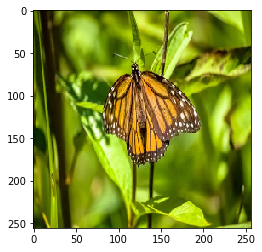

<class 'PIL.Image.Image'>


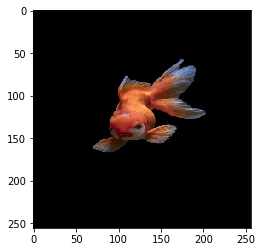

<class 'PIL.Image.Image'>


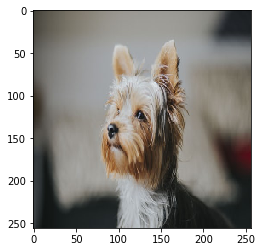

In [2]:
for name in os.listdir(photo_location):
    if name.startswith('.'): continue 
    
    # Note the target_size parameter
    image = keras_image.load_img(photo_location + name, target_size=(256, 256))
    print(type(image))
    plt.imshow(image)
    plt.show()

This is enough to let our neural networks process the images, since they're the same size. But the images have been squashed. I hope we all agree the goldfish in particular looks a bit less fish-like then it did before... 

There has been some discussion of adding this option to Keras, but to my knowledge the feature has never been adopted. See this PR for more: https://github.com/keras-team/keras/pull/4987

That's okay, we can hack together some code that resizes the image with padding using the Python Image Library (PIL). 

In [3]:
from PIL import Image, ImageOps
import numpy as np

# This function takes an image path, loads the image using PIL
# and then returns version of that image which is padded to be
# square then resized to the specified target. Finally, we'll
# just return the image data as a numpy 3D array, which is better
# for the rest of our processing goals. 

# As shown above, keras relies on PIL under the hood already
# so this is a good way to go without adding dependencies. 
def load_maintain_aspect_ratio(input_image_path, target_size):
    image = Image.open(input_image_path)
    width, height = image.size
    
    w_pad = 0
    h_pad = 0
    bonus_h_pad = 0
    bonus_w_pad = 0
    
    if width > height:
        pix_diff = (width - height)
        h_pad = pix_diff // 2
        bonus_h_pad = pix_diff % 2 # If the difference was odd, add one pixel on one side.
    elif height > width:
        pix_diff = (height - width)
        w_pad = pix_diff // 2
        bonus_w_pad = pix_diff % 2 # If the difference was odd, add one pixel on one side.
    # else: image is already square. Both pads stay 0
    
    image = ImageOps.expand(image, (w_pad, h_pad, w_pad+bonus_w_pad, h_pad+bonus_h_pad))
    image = image.resize(target_size)
    
    # Last thing: we're going to scale all the default (0-255) RGB
    # values to be floats from 0-1. If we do not do this in some cases
    # the generators we use below wrongly interpret the int's as floats
    # and clip values greater than 1. It's a strange bug you wouldn't expect
    # so it's better to just handle it here!
    image_data = np.array(image.getdata()).reshape(image.size[0], image.size[1], 3)
    
    return np.divide(image_data, 255)

<class 'numpy.ndarray'>


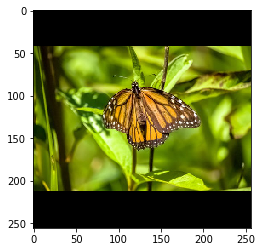

<class 'numpy.ndarray'>


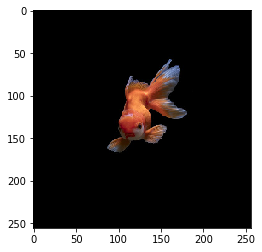

<class 'numpy.ndarray'>


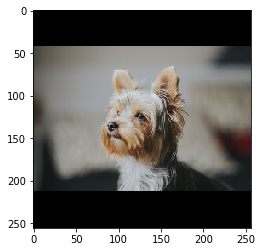

In [4]:
for name in os.listdir(photo_location):
    if name.startswith('.'): continue 
    
    # Note the target_size parameter
    image = load_maintain_aspect_ratio(photo_location + name, target_size=(256, 256))
    print(type(image))
    plt.imshow(image)
    plt.show()

This is much better. Now, we'll marvel at how much work Keras does for us with the incredible ImageDataGenerator class:

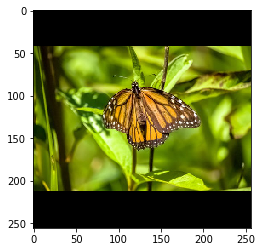

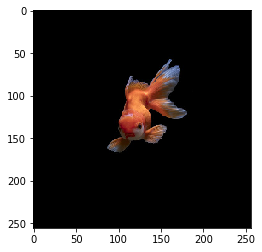

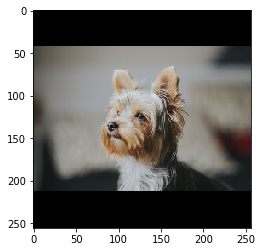

In [5]:
# Load the images, we'll use this repeatedly.
images = []
labels = np.array([0, 1, 2]) # This are required for flow, which we'll see soon.
for name in os.listdir(photo_location):
    if name.startswith('.'): continue 
    
    # Note the target_size parameter
    image = load_maintain_aspect_ratio(photo_location + name, target_size=(256, 256))
    images.append(image)
    
# Just prove to ourselves nothing has changed here:
images = np.array(images)
for im in images:
    plt.imshow(im)
    plt.show()

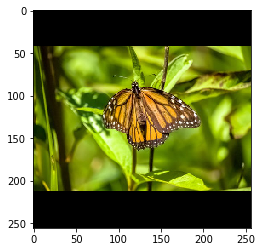

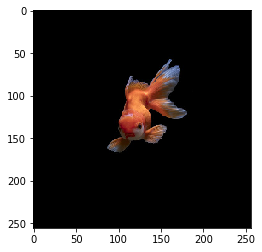

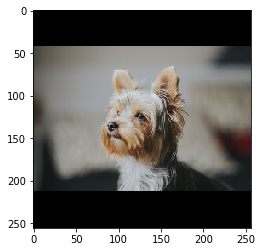

In [6]:
from keras.preprocessing.image import ImageDataGenerator

# This class creates a generator that yields images. 
# The arguments all relate to things we can ask Keras to do
# to the images passed into the generator before each image is yielded. 
# If we use the default values (As we are below) then we'll just get the
# same images back. Taken all at once it's a bit overwhelming. Lets just
# show how to use this to get the images back out:
# datagen = ImageDataGenerator(
#     featurewise_center=False,
#     samplewise_center=False,
#     featurewise_std_normalization=False,
#     samplewise_std_normalization=False,
#     zca_whitening=False,
#     zca_epsilon=1e-06,
#     rotation_range=0,
#     width_shift_range=0.0,
#     height_shift_range=0.0,
#     brightness_range=None,
#     shear_range=0.0, 
#     zoom_range=0.0, 
#     channel_shift_range=0.0, 
#     fill_mode='nearest', 
#     cval=0.0,
#     horizontal_flip=False,
#     vertical_flip=False,
#     rescale=None,
#     preprocessing_function=None,
#     data_format=None,
#     validation_split=0.0,
#     dtype=None)

# Lets start with the default!
datagen = ImageDataGenerator()

# The flow method loops forever by design, as it's meant to be used in combination
# with keras fit_generator method. Each time we loop it will yield a batch of images
# which, by default, will be ALL of them. With the default parameters, it will yield
# our three original images
for image_batch, label_batch in datagen.flow(images, labels):
    for image, label in zip(image_batch, label_batch):
        plt.imshow(image)
        plt.show()
        
    break # to avoid infinity...

In [37]:
# Make a quick helper so we don't copy this code over and over...
# And make the display a little nicer. 
def display_images(datagen, rounds=1):
    plt.figure(figsize=(15, 10))

    i = 0
    for image_batch, label_batch in datagen.flow(images, labels):
        j = 1
        for image, label in zip(image_batch, label_batch):
            ax = plt.subplot(rounds, 3, (i*3)+j)
            ax.axis('off')
            plt.imshow(image)
            
            j += 1

        i += 1
        if i >= rounds: break # to avoid infinity...
        
            
    plt.tight_layout()
    plt.show()

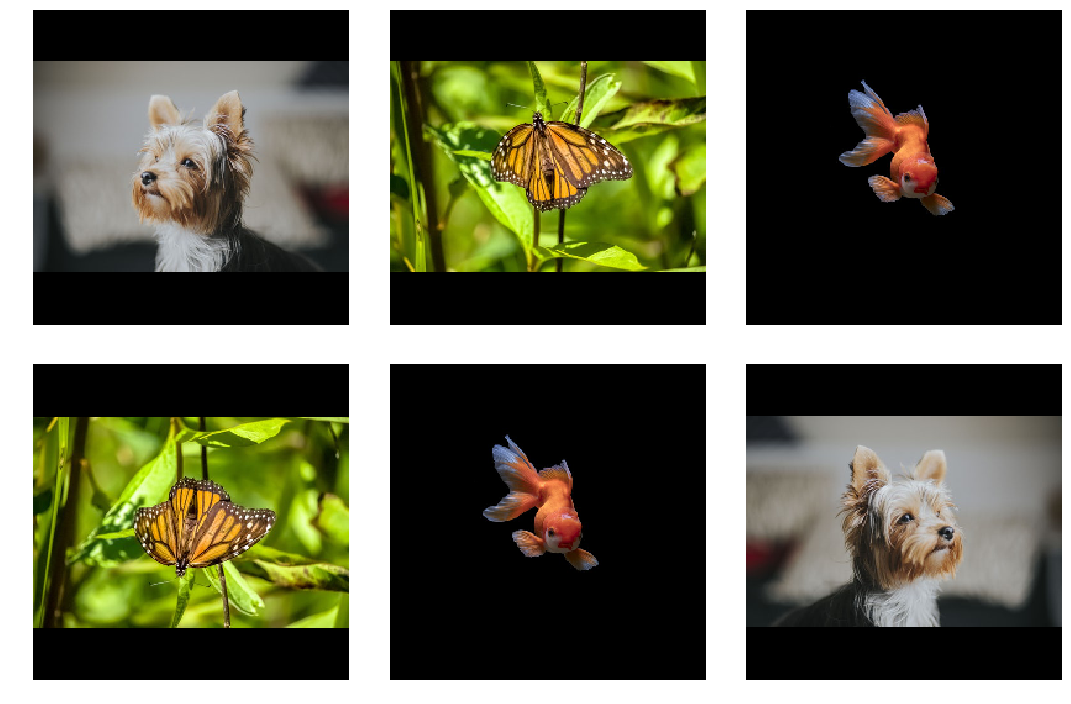

In [38]:
# Add some flips:
datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
)

display_images(datagen, 2)

Can you tell what the data generator did here? 

We ran through 2 rounds of data generation and the images were randomly shuffled, and the augmentation we asked for (flips) was randomly applied. Lets look at some more!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


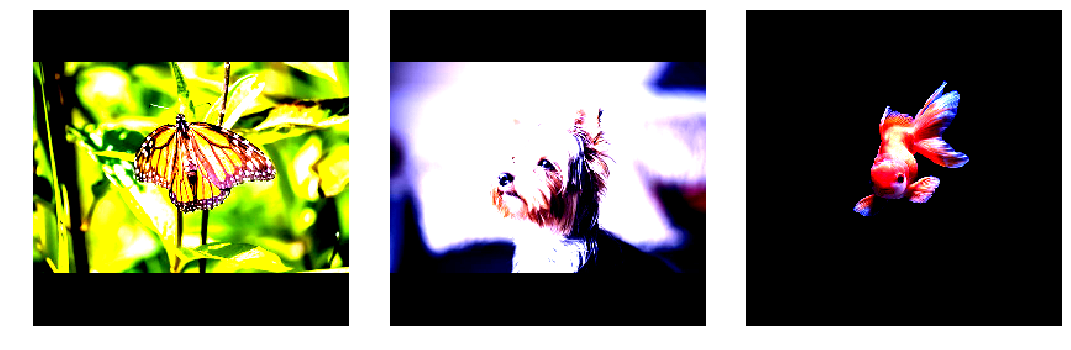

In [39]:
# Normalize the data around, and center it around 0.
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True
)

# Our requested transformation will not applied without .fit, 
# because this particular transformation requires information 
# about the data being passed in.
datagen.fit(images)

# We can see from the warnings that these transformations do not maintain the 0-1ness of our data
# In fact, these two combined normalize the data so that the mean is 0 and the std_deviation is 1
# which means we can't really visualize the data perfectly anymore... but you can still get an idea
# of how this transform changes the image data by looking at it:
display_images(datagen, 1)

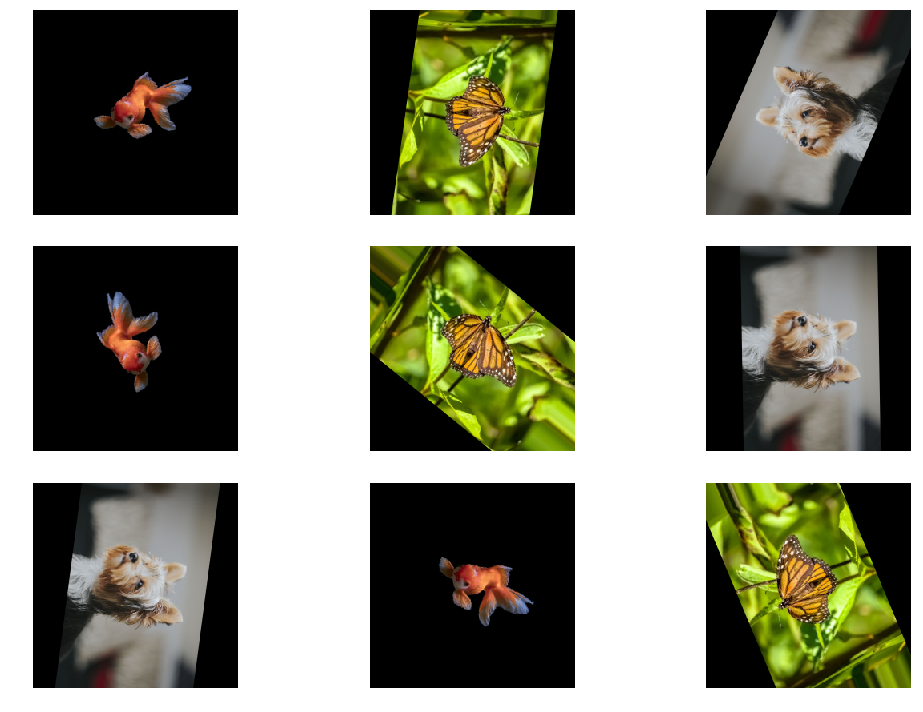

In [40]:
# Random rotations
datagen = ImageDataGenerator(
    rotation_range=360
)

# we don't really have to fit for this one, but it's a good idea 
# to always add this code anyway. It doesn't hurt. 
datagen.fit(images)
display_images(datagen, 3)

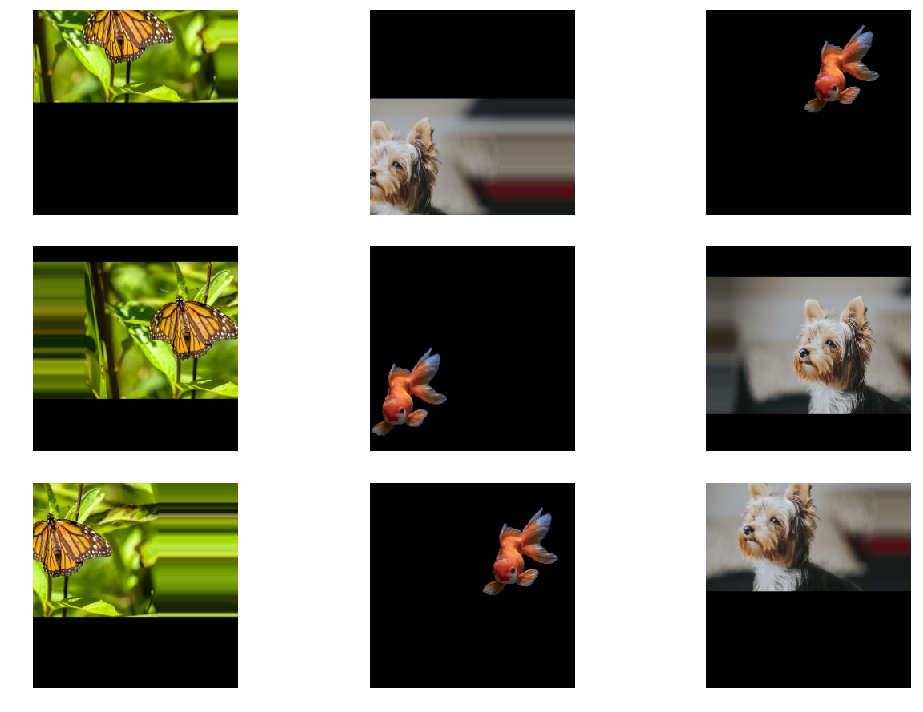

In [41]:
# Shift things around, notice here that the edges of some
# of these images gets pretty weird... we can tell the 
# preprocessor to do something different when it has to 
# fill in pixels that don't exist... see next 
datagen = ImageDataGenerator(
    width_shift_range=100.0,
    height_shift_range=100.0,
)


datagen.fit(images)
display_images(datagen, 3)

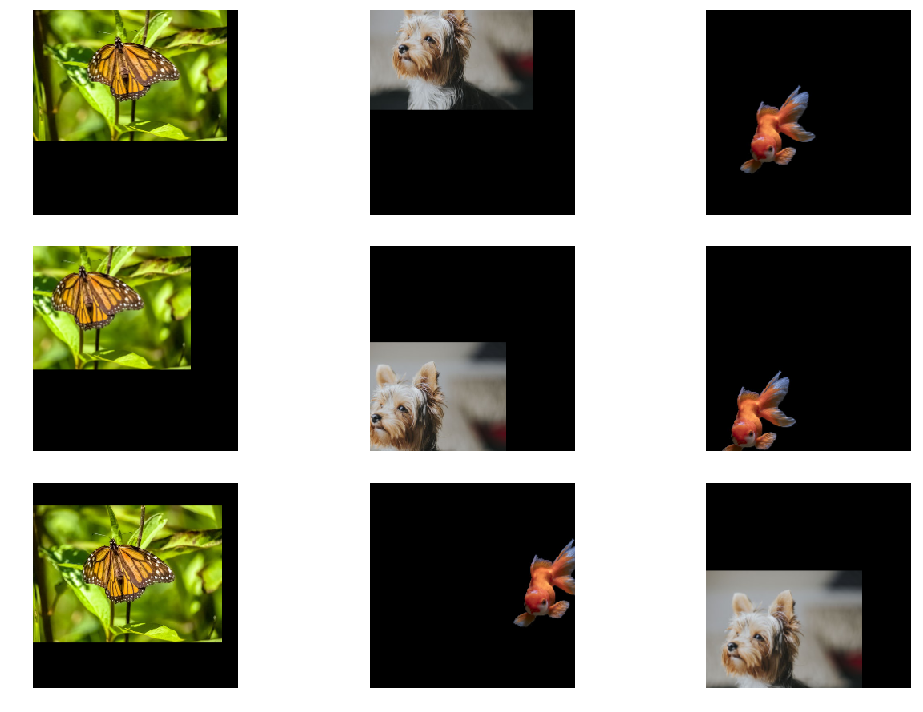

In [42]:
# I prefer this to the default "nearest" 
# esp. since we're already padding images 
# to squares with black pixels. 
datagen = ImageDataGenerator(
    width_shift_range=100.0,
    height_shift_range=100.0,
    fill_mode='constant',
    cval=0 # black
)

datagen.fit(images)
display_images(datagen, 3)

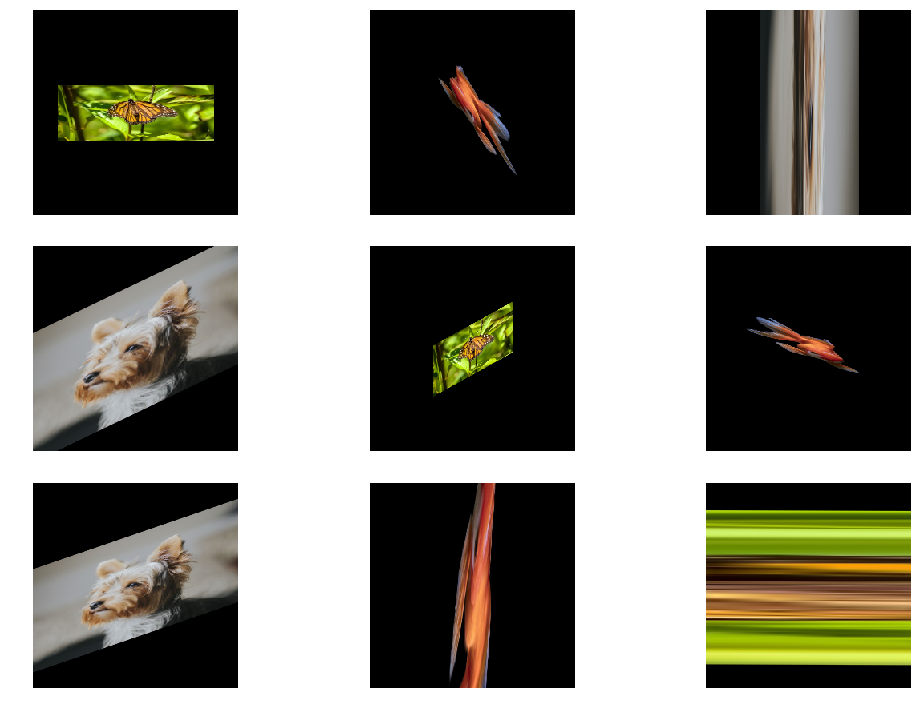

In [43]:
# Shear, zoom. Taken to the extreme these aren't that useful...
datagen = ImageDataGenerator(
    shear_range=360.0, # 0-360, degrees
    zoom_range=2.0,    # Scalar, this allows 2x zoom factor
    fill_mode='constant',
    cval=0 # black
)

# I hope you agree some of these images might as well be noise, and would 
# damage our network's ability to learn. 
datagen.fit(images)
display_images(datagen, 3)

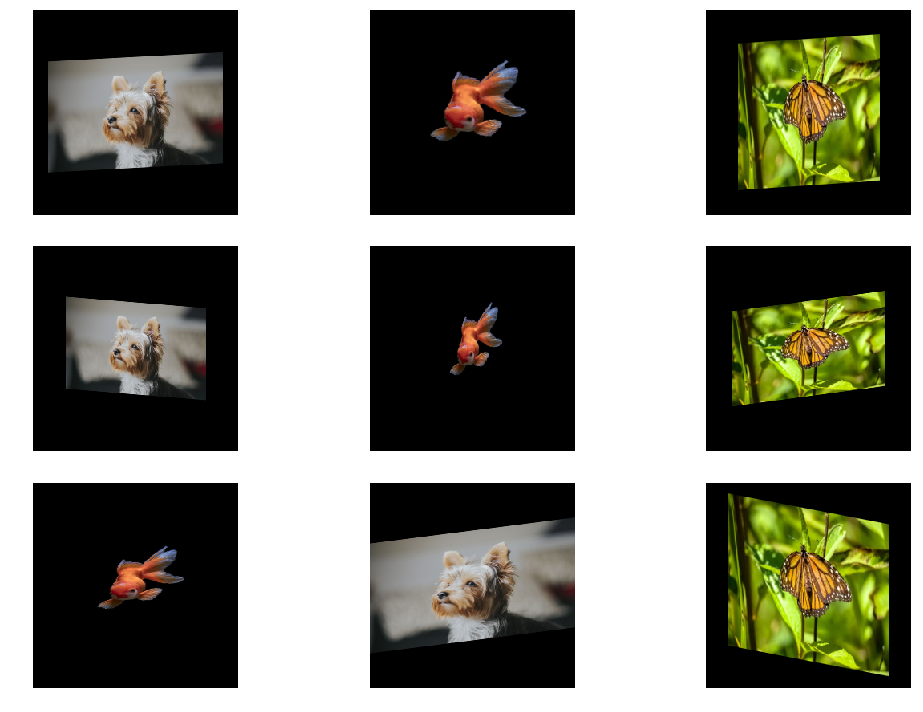

In [44]:
# Shear, zoom. But less extreme, esp. shear
# 
datagen = ImageDataGenerator(
    shear_range=10.0, # 0-10, degrees
    zoom_range=.5,    # Scalar, this allows increase/decrease size by 50%
    fill_mode='constant',
    cval=0 # black
)


datagen.fit(images)
display_images(datagen, 3)

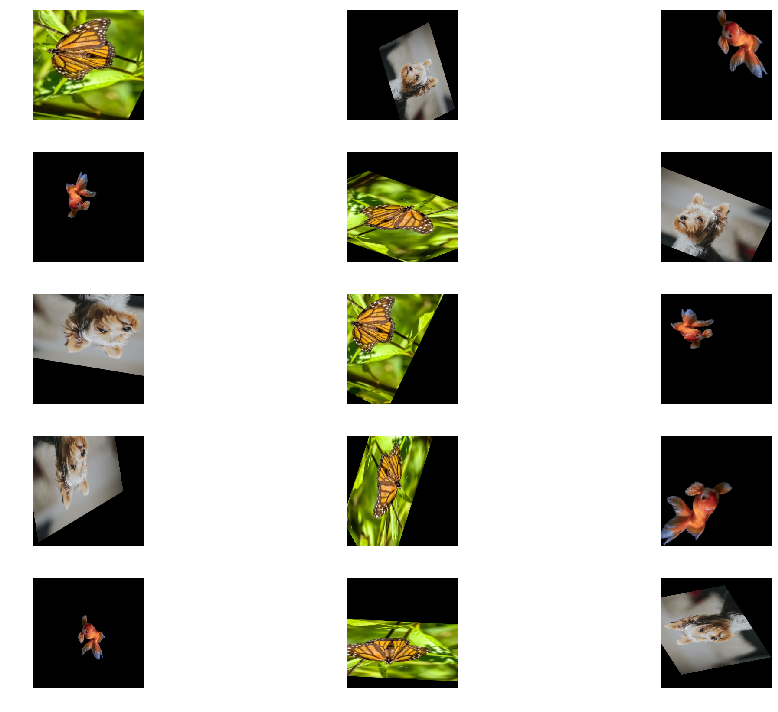

In [46]:
# Taken all together, these transformations may increase the time it takes to train
# but that's okay... they also have been shown to significantly improve performance
# plus, they essentially expand the total size of our dataset, which can allow us
# to perform deep learning while collecting less data! 

# Lets look at one last thing, a good starting point for a genuine generator for use 
# on a real system:

datagen = ImageDataGenerator(
    rotation_range=360,
    width_shift_range=0.2,   # As a float this is the fraction of the width
    height_shift_range=0.2,  # As a float this is the fraction of the height
    shear_range=10, 
    zoom_range=0.5, 
    fill_mode='constant', 
    cval=0.0
)

datagen.fit(images) # This takes awhile now!
display_images(datagen, 5)